# Garbage Classification using MobilenetV2

# Import Required Libraries

In [103]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


# Define Constants

In [104]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "../projeto6/garbage_classification/"

# Dictionary to save our 12 classes
categories={}
i=0
for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        if dirname.split('/')[-1] != '':
            categories[i] = dirname.split('/')[-1]
            i += 1
            break
print(categories)
print('defining constants successful!')

{0: 'paper', 1: 'green-glass', 2: 'clothes', 3: 'metal', 4: 'cardboard', 5: 'trash', 6: 'biological', 7: 'white-glass', 8: 'battery', 9: 'brown-glass', 10: 'plastic', 11: 'shoes'}
defining constants successful!


# Create DataFrame

We want to create a data frame that has in one column the filenames of all our images and in the other column the corresponding category. 
We Open the directories in the dataset one by one, save the filenames in the filenames_list and add the corresponding category in the categories_list

In [105]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x if re.search("\d", x) is None else x[:re.search("\d", x).start()] + '/' + x)
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  + filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [106]:
df.head(10)

filename  category
0  white-glass/white-glass603.jpg         7
1         clothes/clothes1140.jpg         2
2         clothes/clothes1157.jpg         2
3         clothes/clothes4379.jpg         2
4         clothes/clothes3670.jpg         2
5    biological/biological228.jpg         6
6          clothes/clothes980.jpg         2
7              trash/trash143.jpg         5
8          plastic/plastic460.jpg        10
9         clothes/clothes3001.jpg         2

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15515 entries, 0 to 15514
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  15515 non-null  object
 1   category  15515 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 242.5+ KB


# Visualize some images

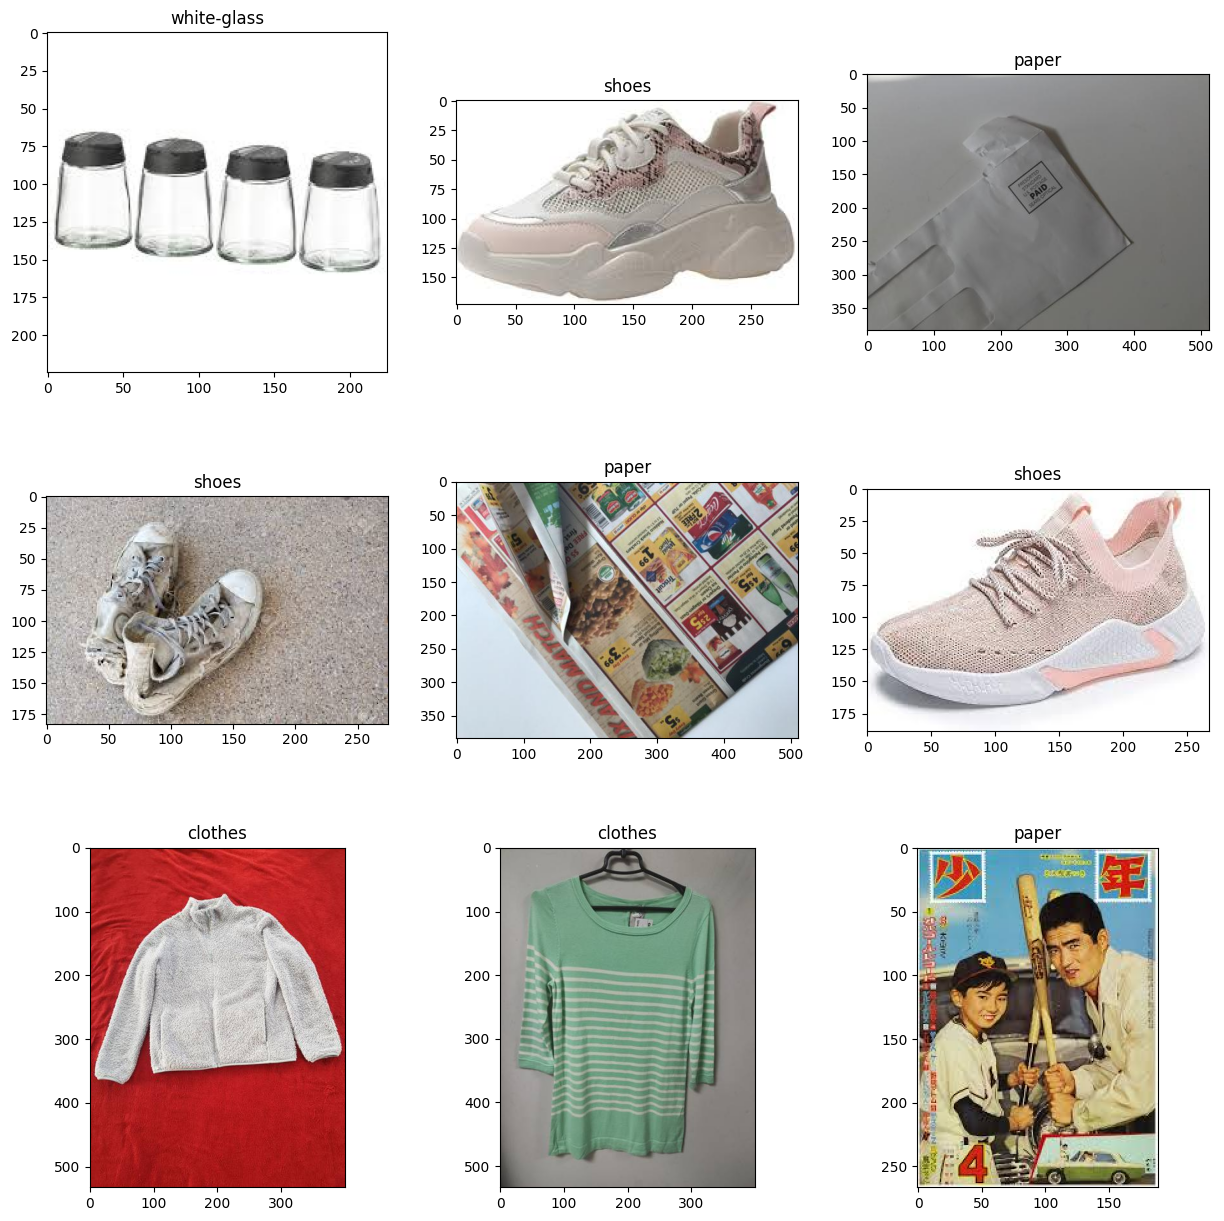

In [108]:
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = image.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(categories[sample['category']])
    plt.imshow(random_image)
plt.show()

# Viusalize the Categories Distribution

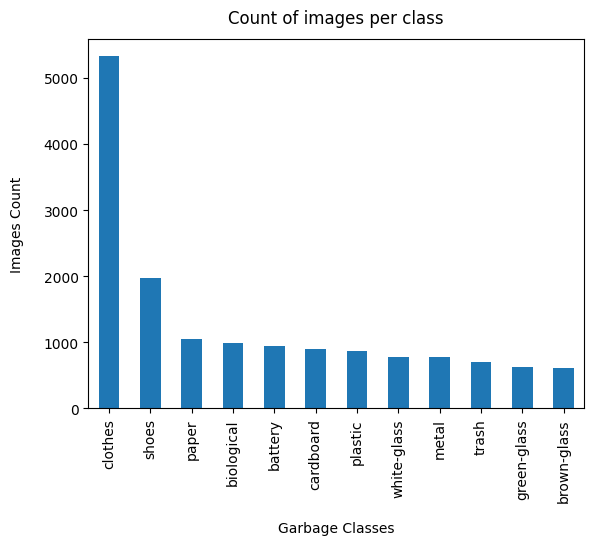

In [109]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# Create the model

The steps are:
1. Create an mobilenetv2 model without the last layer and load the ImageNet pretrained weights
2. Add a pre-processing layer
3. Add a pooling layer followed by a softmax layer at the end

In [110]:
from keras.models import Sequential
from keras.layers import Dense
import keras.applications.mobilenet_v2 as mobilenetv2

mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = '../projeto6/weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 12)                15372     
                                                                 
Total params: 2273356 (8.67 MB)
Trainable params: 15372 (60.05 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


We will use the EarlyStopping call back to stop our training if the validation_accuray is not improving for a certain number of epochs.

In [111]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


# Split the Data Set

We split the training set into three separate sets:

1. **The training set:** used to train our model.
1. **The validation set**: used to double check that our model is not overfitting the training set, i.e. it can also generalise to other data other than the train data
1. **The Test set:** Used to estimate the accuracy of the model on new data other than the ones the model used for training
For a competition  or for some other cases, you can split the data only to training and validation sets in order to achieve the highest  possible accuracy, without the need to properly estimate how accurate the model really is.

We split the data set as follows: 80% train set, 10% cross_validation set, and 10% test set

In [112]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  2172 validate size =  2172 test size =  931


In [113]:
df.category.unique()

array(['white-glass', 'clothes', 'biological', 'trash', 'plastic',
       'shoes', 'cardboard', 'paper', 'battery', 'metal', 'brown-glass',
       'green-glass'], dtype=object)

# Train the model

We will first create the training data generator, that will get the images from the input data directory to train on them. We will also create a generator for the validation set.

Applying Data Augmentation on the training set was taking too long to be executed and the initial results didn't show much improvement than the results without augmentation, so I commented the augmentation to make the training faster. However fell free to uncomment the Data Augmentation lines in the following cell and play a bit with it.

In [114]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [115]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2172 validated image filenames belonging to 12 classes.


In [116]:
EPOCHS = 7
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    #callbacks=callbacks
)

Epoch 1/7
193/193 [==============================] - 141s 725ms/step - loss: 0.6876 - categorical_accuracy: 0.7937 - val_loss: 0.3419 - val_categorical_accuracy: 0.8991
Epoch 2/7
193/193 [==============================] - 157s 810ms/step - loss: 0.3525 - categorical_accuracy: 0.8907 - val_loss: 0.2607 - val_categorical_accuracy: 0.9223
Epoch 3/7
193/193 [==============================] - 171s 887ms/step - loss: 0.2876 - categorical_accuracy: 0.9116 - val_loss: 0.2315 - val_categorical_accuracy: 0.9200
Epoch 4/7
193/193 [==============================] - 214s 1s/step - loss: 0.2674 - categorical_accuracy: 0.9147 - val_loss: 0.2199 - val_categorical_accuracy: 0.9257
Epoch 5/7
193/193 [==============================] - 204s 1s/step - loss: 0.2594 - categorical_accuracy: 0.9173 - val_loss: 0.2169 - val_categorical_accuracy: 0.9276
Epoch 6/7
193/193 [==============================] - 203s 1s/step - loss: 0.2319 - categorical_accuracy: 0.9240 - val_loss: 0.2093 - val_categorical_accuracy: 0.

In [117]:
model.save_weights("model_wights.h5")
tf.keras.models.save_model(model, "garbage_class_model.keras")

# Visualize the training process


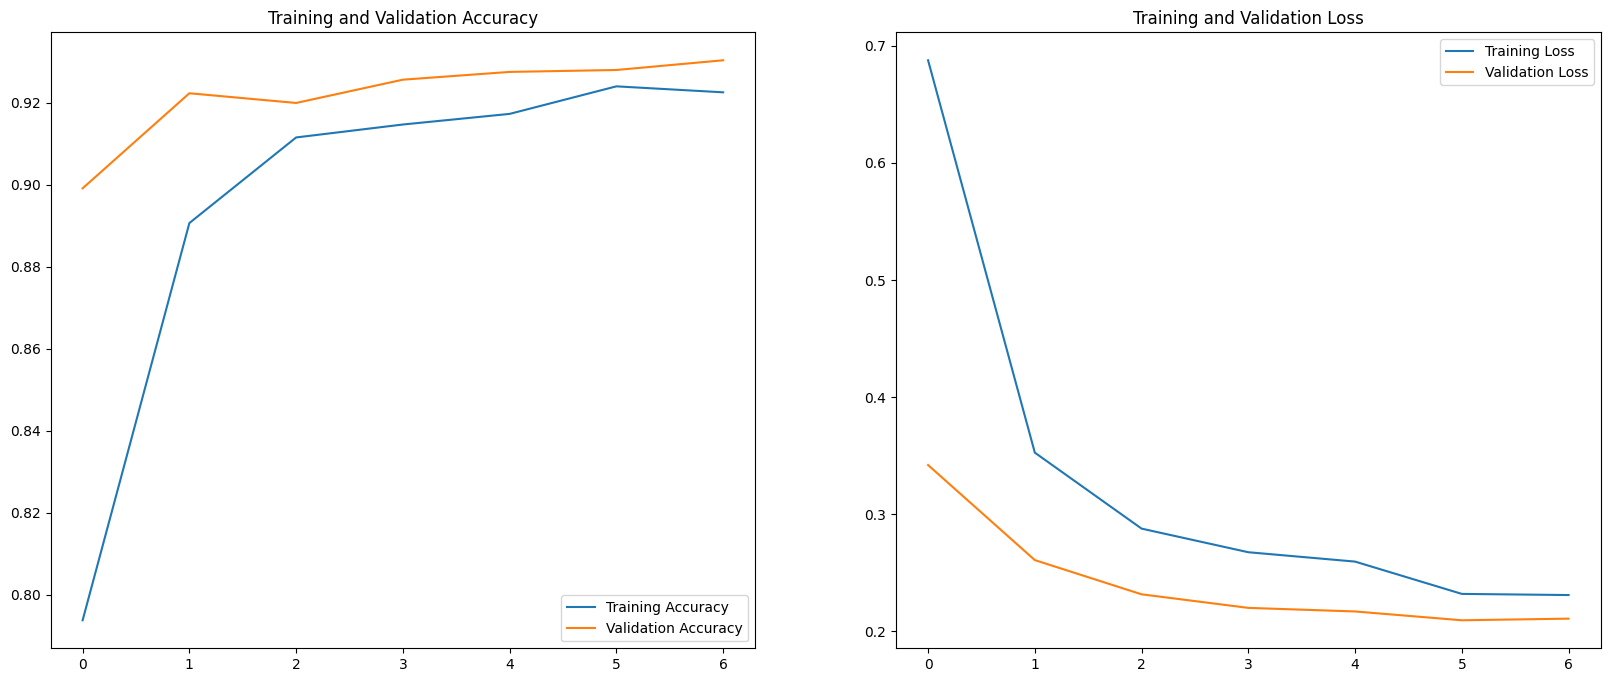

In [118]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(7)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the test

To evaluate the performance of our model we will create a test generator to load the images from the input data directory and evaluate the results.

In [119]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 931 validated image filenames belonging to 12 classes.


In [120]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

/var/folders/h7/q0630v0j18n1580txfr75yx80000gn/T/ipykernel_7031/3470922143.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Accuracy on test set =  93.45 % 


In [121]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [122]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

/var/folders/h7/q0630v0j18n1580txfr75yx80000gn/T/ipykernel_7031/727984934.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.97      0.85      0.91        75
  biological       0.99      0.99      0.99        67
 brown-glass       0.96      0.89      0.93        28
   cardboard       0.94      0.86      0.90        58
     clothes       0.98      0.99      0.99       310
 green-glass       0.86      0.95      0.90        40
       metal       0.79      0.91      0.85        55
       paper       0.85      0.89      0.87        71
     plastic       0.88      0.88      0.88        48
       shoes       0.93      0.97      0.95       100
       trash       0.95      0.90      0.92        41
 white-glass       0.91      0.82      0.86        38

    accuracy                           0.93       931
   macro avg       0.92      0.91      0.91       931
weighted avg       0.94      0.93      0.93       931



The table above shows among other info the F1 score of each category. In the bottom of the F1 score column notice two numbers accuracy and macro avg. Accuracy is the same accuracy that we evaluated above for the test set, it is a weighted average. 

However the macro avg (unweighted average) is a bit less than accuracy. This is because the clothes category, the category which has by far the largest number of images, has a very high F1 score, so accuracy (the weighted average) is higher than the unweighted average (macro avg).

For this problem I would consider the macro avg a better measure of accuracy as it takes an average of all the F1 scores regardless of how much data we have in the training data for each category.

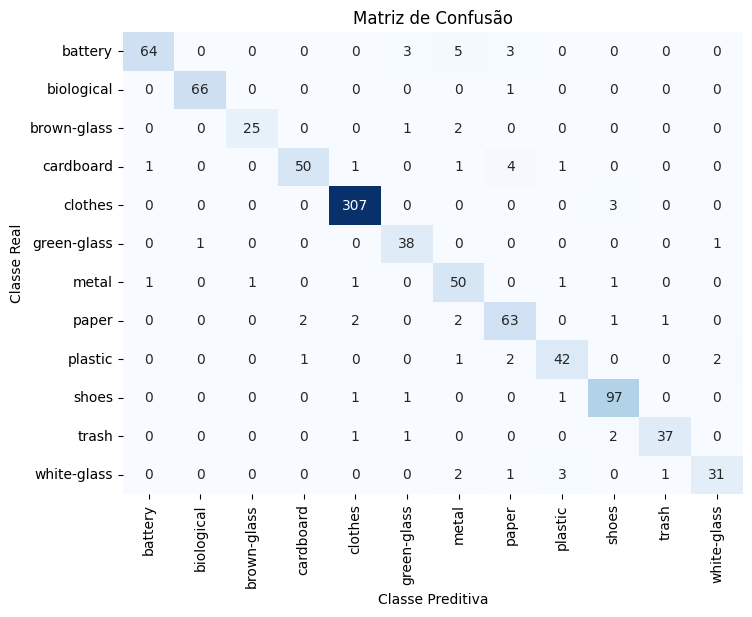

In [123]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(labels, preds)

# Crie o gráfico da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=gen_label_map.values(), yticklabels=gen_label_map.values())
plt.xlabel('Classe Preditiva')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

# Test with photos that I took

1/1 [==============================] - 0s 25ms/step


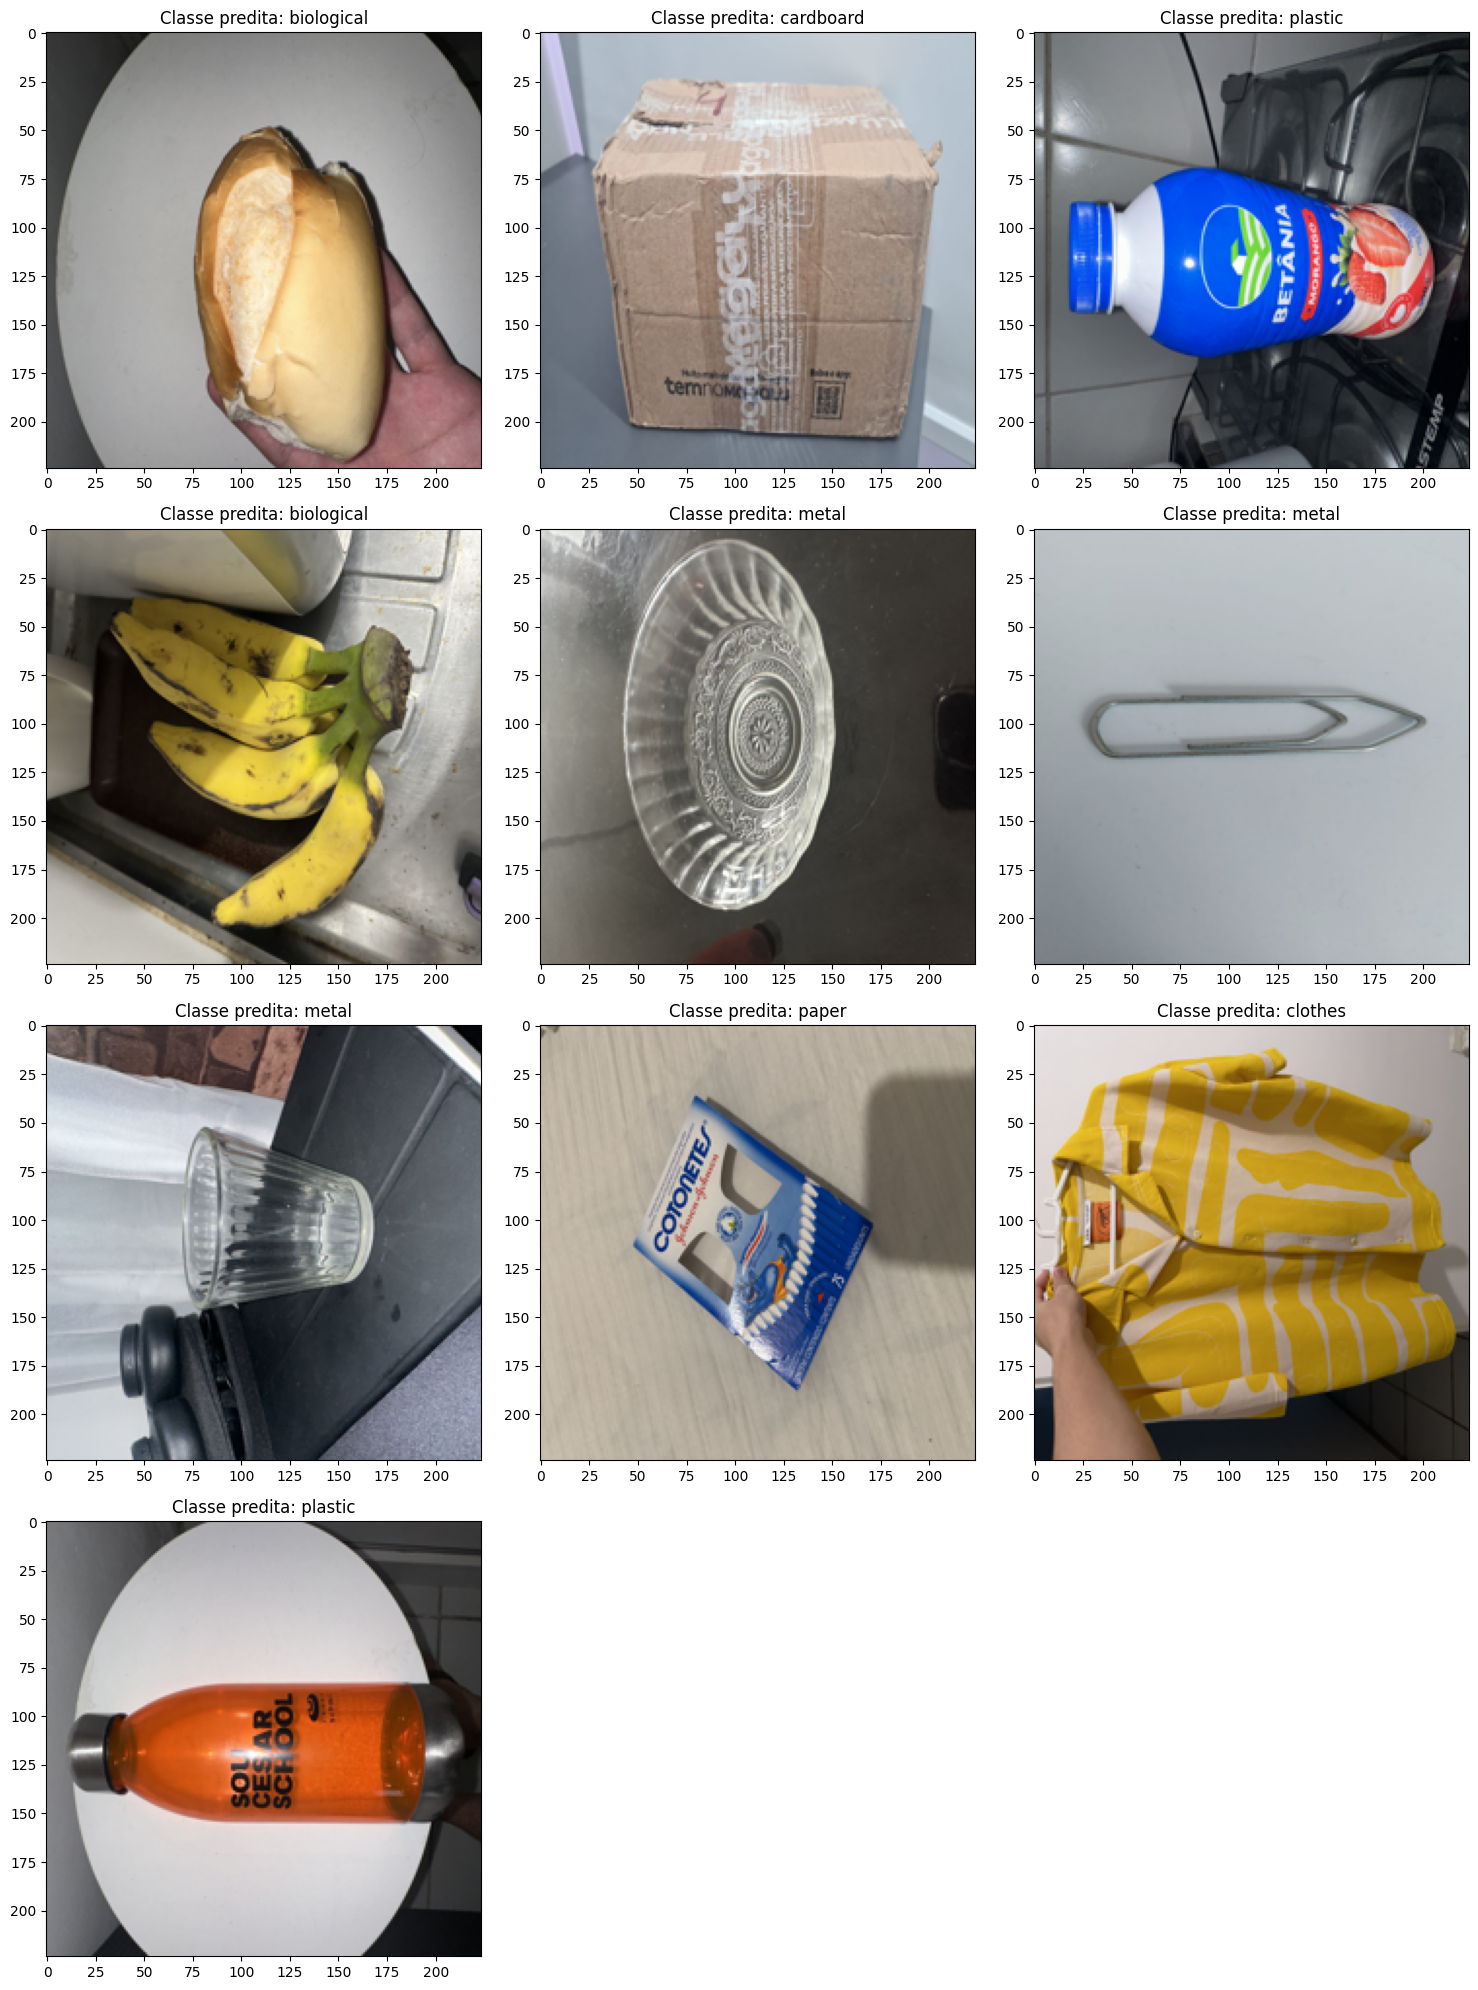

In [131]:
# Lista de caminhos para as imagens
caminhos_imagen = ['../projeto6/self_images/' + x for x in os.listdir('../projeto6/self_images/')]

# Listas para armazenar as imagens e previsões
imagens = []
previsoes = []

# Carregue as imagens, faça previsões e armazene os resultados
for caminho in caminhos_imagen:
    imagem = Image.open(caminho)
    imagem = imagem.resize(IMAGE_SIZE)
    imagem_array = tf.keras.preprocessing.image.img_to_array(imagem)
    imagem_array = np.expand_dims(imagem_array, axis=0)
    previsao = model.predict(imagem_array)
    imagens.append(imagem)
    previsoes.append(previsao)

# Configurações para o grid de subplots
num_imagens = len(caminhos_imagen)
num_linhas = (num_imagens + 2) // 3  # Arredonde para cima

# Crie o grid de subplots
fig, axs = plt.subplots(num_linhas, 3, figsize=(15, 5 * num_linhas))

for i in range(num_imagens):
    linha = i // 3
    coluna = i % 3
    axs[linha, coluna].imshow(imagens[i])
    classe_predita = gen_label_map[np.argmax(previsoes[i])]
    axs[linha, coluna].set_title(f'Classe predita: {classe_predita}')

# Remova subplots vazios, se houver
for i in range(num_imagens, num_linhas * 3):
    linha = i // 3
    coluna = i % 3
    fig.delaxes(axs[linha, coluna])

plt.tight_layout()
plt.show()
